# Simulate Data Noisy

In [1]:
import os, sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

leaspy_path = '/network/lustre/dtlake01/aramis/users/juliette.ortholand/leaspy/'

sys.path.append(leaspy_path)

In [2]:
from leaspy import Leaspy, IndividualParameters, AlgorithmSettings, Data

## Use `simulate_privacy` branch !

In [3]:
import os
path_head = os.path.join(leaspy_path, '.git/HEAD')
with open(path_head, 'r') as f:
    head = f.read()
    
if head.replace('\n', '').split('/')[-1] == 'simulate_privacy':
    print('You are good to run or modify this file!')
else:
    raise EnvironmentError('PLEASE USE simulate_privacy leaspy branch!')

You are good to run or modify this file!


## Run simulation

### Hyper-parameters

In [4]:
mean_number_of_visits=10
number_of_subjects=200
prefix='GS-'  # For the generated subjects' IDs - ex: GS-001, GS-002 etc

### First simulation to get noise level per feature

In [5]:
ppmi_df = pd.read_csv('df_ppmi_iPD.csv', dtype={'ID': str}).set_index(['ID', 'TIME'])
ppmi_data = Data.from_dataframe(ppmi_df)
# ---- Load model & IP
ppmi_leaspy = Leaspy.load('model_parameters-10_sources.json')
ppmi_ip = IndividualParameters.load('individual_parameters-10_sources.csv')
# ---- First simulation
settings = AlgorithmSettings('simulation', 
                             sources_method='full_kde', 
                             mean_number_of_visits=mean_number_of_visits, 
                             number_of_subjects=number_of_subjects, 
                             prefix=prefix,
                            seed=0)
results = ppmi_leaspy.simulate(ppmi_ip, ppmi_data, settings)

for feat, noise in zip(ppmi_leaspy.model.features, results.noise_std):
    print(feat, f' - noise = {noise:.3f}')

MDS1_total  - noise = 0.053
MDS2_total  - noise = 0.055
MDS3_off_total  - noise = 0.064
SCOPA_total  - noise = 0.074
MOCA_total  - noise = 0.058
REM_total  - noise = 0.126
PUTAMEN_R  - noise = 0.062
PUTAMEN_L  - noise = 0.058
CAUDATE_R  - noise = 0.069
CAUDATE_L  - noise = 0.069


### Increase noise for SCOPA

In [17]:
new_noise = results.noise_std.clone().detach()
new_noise[3] = .4
for feat, noise in zip(ppmi_leaspy.model.features[3:4], new_noise[3:4]):
    print(feat, f' - noise = {noise:.3f}')

SCOPA_total  - noise = 0.400


### Simulation with noisy SCOPA

In [18]:
simu_path = 'simulated_data-noisy_SCOPA.csv'


settings = AlgorithmSettings('simulation', 
                             sources_method='full_kde', 
                             mean_number_of_visits=mean_number_of_visits, 
                             number_of_subjects=number_of_subjects, 
                             prefix=prefix,
                             noise=new_noise.tolist(),
                            seed=0)
results_noisy = ppmi_leaspy.simulate(ppmi_ip, ppmi_data, settings)

simu_df = results_noisy.data.to_dataframe().set_index(['ID', 'TIME'])
simu_df.to_csv(simu_path)

for feat, noise in zip(ppmi_leaspy.model.features, results_noisy.noise_std):
    print(feat, f' - noise = {noise:.3f}')

 ==> Setting seed to 0
MDS1_total  - noise = 0.053
MDS2_total  - noise = 0.055
MDS3_off_total  - noise = 0.064
SCOPA_total  - noise = 0.400
MOCA_total  - noise = 0.058
REM_total  - noise = 0.126
PUTAMEN_R  - noise = 0.062
PUTAMEN_L  - noise = 0.058
CAUDATE_R  - noise = 0.069
CAUDATE_L  - noise = 0.069


#### petit warning à corriger un de ces 4.

Text(0.5, 1.0, 'SCOPA_total - Raw data')

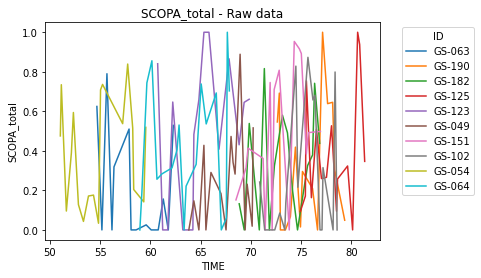

In [19]:
variable = 'SCOPA_total'

var_df = simu_df[[variable]]
visits_per_subjects = var_df.groupby(var_df.index.get_level_values('ID')).count().sort_values(variable)
var_df = var_df.loc[visits_per_subjects.loc[visits_per_subjects[variable] > 3].index]

idx_list = visits_per_subjects.tail(10).index

sns.lineplot(data=var_df.loc[idx_list].reset_index(), x='TIME', y=variable, hue='ID')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='ID')
plt.title(variable + ' - Raw data')